In [1]:
import pandas as pd
import pickle
%pylab inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures,RobustScaler

import scipy.stats as stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
horror_df=pd.read_pickle('horror_df.pkl')
horror_df

,Movie,Year,Runtime_min,Genres,IMDB_Score,IMDB_Votes,Metascore,Director,Star,Budget,...,Novel_Adaptation,Male_Score,Male_Total_Votes,Female_Score,Female_Total_Votes,Link_stub,Female_Protagonist,Creature_Feature,Cult_Classic,Murder
0,Psycho,1960,109,"[Horror, Mystery, Thriller ]",8.5,602815,97,Alfred Hitchcock,"[Anthony Perkins, Janet Leigh, Vera Miles]",806947,...,1,8.5,353389,8.4,88145,/title/tt0054215/,0,0,1,1
1,The Shining,1980,146,"[Drama, Horror ]",8.4,896027,66,Stanley Kubrick,"[Jack Nicholson, Shelley Duvall, Danny Lloyd]",19000000,...,1,8.4,530475,8.3,124287,/title/tt0081505/,0,0,1,1
2,Alien,1979,117,"[Horror, Sci-Fi ]",8.4,786083,89,Ridley Scott,"[Sigourney Weaver, Tom Skerritt, John Hurt]",11000000,...,0,8.5,507612,8.2,73461,/title/tt0078748/,1,1,1,1
3,The Thing,1982,109,"[Horror, Mystery, Sci-Fi ]",8.1,370424,57,John Carpenter,"[Kurt Russell, Wilford Brimley, Keith David]",15000000,...,0,8.2,252886,7.7,28831,/title/tt0084787/,0,1,1,1
4,What Ever Happened to Baby Jane?,1962,134,"[Drama, Horror, Thriller ]",8.1,49967,75,Robert Aldrich,"[Bette Davis, Joan Crawford, Victor Buono]",980000,...,1,8.0,28768,8.3,10292,/title/tt0056687/,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Slender Man,2018,93,"[Horror, Mystery, Thriller ]",3.2,28703,30,Sylvain White,"[Joey King, Julia Goldani Telles, Jaz Sinclair]",10000000,...,0,3.2,14850,3.4,4180,/title/tt5690360/,0,1,0,1
680,Jaws: The Revenge,1987,89,"[Adventure, Horror, Thriller ]",3.0,41154,15,Joseph Sargent,"[Lorraine Gary, Lance Guest, Mario Van Peebles]",23000000,...,0,2.9,27697,3.6,3417,/title/tt0093300/,0,0,0,0
681,BloodRayne,2005,95,"[Action, Fantasy, Horror ]",2.9,34131,18,Uwe Boll,"[Kristanna Loken, Ben Kingsley, Michelle Rodri...",25000000,...,0,2.9,25173,3.1,3255,/title/tt0383222/,1,0,1,1
682,Alone in the Dark,2005,96,"[Action, Horror, Sci-Fi ]",2.4,41668,9,Uwe Boll,"[Christian Slater, Tara Reid, Stephen Dorff]",20000000,...,0,2.3,30832,2.6,3395,/title/tt0369226/,0,1,1,1


In [3]:
#removing outlier residuals

horror_df=horror_df.drop([681])
horror_df=horror_df.drop([682])
horror_df=horror_df.drop([683])
horror_df=horror_df.drop([668])

In [4]:
#sns.pairplot(horror_df,plot_kws=dict(alpha=.2,edgecolor='none'));

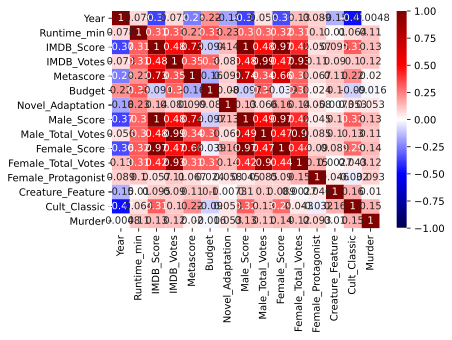

In [5]:
horror_df.corr()
sns.heatmap(horror_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [6]:
#creating final sets for regression
Xms=horror_df.loc[:,['Year','Runtime_min','Male_Score','Novel_Adaptation',
                  'Female_Protagonist','Creature_Feature',
                  'Cult_Classic','Murder','Metascore']]
y=horror_df['Female_Score']

In [7]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(horror_df.Genres)
Genre_dum=pd.DataFrame(dum,horror_df.index,mlb.classes_)
combined_X=pd.concat([Genre_dum,Xms],axis=1)
Xms=combined_X
y=horror_df['Female_Score']

In [8]:
dir_counts=horror_df.Director.value_counts()
other_d = list(dir_counts[dir_counts <= 3].index)
Xms['Director']=horror_df['Director'].replace(other_d,'Other')
Xms=pd.get_dummies(Xms, drop_first=True)
y=horror_df['Female_Score']

In [9]:
#train,test,val split
X_train_val, X_test, y_train_val, y_test = train_test_split(Xms, y, test_size=0.2,random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=41)

In [10]:
#analysis of simple linear regression 
model=sm.OLS(y_train,sm.add_constant(X_train))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Female_Score   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     135.1
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          3.76e-207
Time:                        10:28:10   Log-Likelihood:                 132.40
No. Observations:                 408   AIC:                            -140.8
Df Residuals:                     346   BIC:                             107.9
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            4.7526      1.452      3.273      0.001       1.897       7.608
 Adventure                       0.1018      0.080      1.269      0.205      -0.056       0.260
 Comedy                          0.1472      0.087      1.699      0.090      -0.023       0.318
 Comedy                          0.5439      0.209      2.596      0.010       0.132       0.956
 Crime                          -0.0318      0.102     -0.311      0.756      -0.233       0.169
 Crime                           0.5133      0.175      2.929      0.004       0.169       0.858
 Drama                           0.1538      0.067      2.305      0.022       0.023       0.285
 Drama                           0.4809      0.174      2.769      0.006       0.139       0.822
 Family                          0.3824      0.150      2.552      0.011       0.088       0.677
 Family                          0.6713      0.204      3.288      0.001       0.270       1.073
 Fantasy                         0.1590      0.051      3.093      0.002       0.058       0.260
 Fantasy                         0.3703      0.153      2.425      0.016       0.070       0.671
 History                         0.1903      0.207      0.918      0.359      -0.218       0.598
 Horror                          0.2928      0.110      2.671      0.008       0.077       0.508
 Horror                          0.4002      0.150      2.675      0.008       0.106       0.695
 Music                          -0.2179      0.201     -1.083      0.279      -0.613       0.178
 Musical                         1.0603      0.227      4.668      0.000       0.614       1.507
 Musical                         0.5332      0.145      3.676      0.000       0.248       0.818
 Mystery                         0.0066      0.038      0.173      0.863      -0.069       0.082
 Mystery                         0.0778      0.070      1.117      0.265      -0.059       0.215
 Romance                         0.2366      0.134      1.768      0.078      -0.027       0.500
 Sci-Fi                         -0.0130      0.074     -0.174      0.862      -0.159       0.133
 Sci-Fi                          0.0350      0.068      0.517      0.605      -0.098       0.168
 Thriller                        0.1335      0.068      1.976      0.049       0.001       0.266
 Western                        -0.0404      0.180     -0.224      0.823      -0.395       0.314
Action                           0.4249      0.133      3.194      0.002       0.163       0.687
Adventure                        0.2766      0.127      2.183      0.030       0.027       0.526
Animation                        0.3336      0.201      1.658      0.098      -0.062       0.729
Biography                        0.3182      0.229      1.392      0.165    

In [11]:
#validation to check for over-fitting 
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
val_score=lr_model.score(X_val,y_val)
val_score

0.934895300562504

In [12]:
#split for lasso and ridge regressions, validation done inside of gridsearch in pipeline
X_train, X_test, y_train, y_test = train_test_split(Xms, y, test_size=0.2,random_state=41)

In [13]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
robust_pred=pipe.predict(X_test)

In [14]:
r2=r2_score(y_test,robust_pred)
r2

0.9260741787127958

In [15]:
#attempting to calculate adjusted R2, unsure if formula is correct, looking at mean error metrics for model performance
SS_Residual = sum((y_test-robust_pred)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

0.8594368186792597

In [16]:
ridge_coef=list(zip(X_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
ridge_coef
filtered=[(coef,val) for coef,val in ridge_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[(' Drama            ', -0.0040657758813215),
 (' Adventure', 0.004991396156213423),
 (' Sci-Fi', -0.005566742998851153),
 ('Director_Greg McLean', -0.005613084776770337),
 (' Mystery', -0.008550356271725602),
 ('Action', 0.008773551419076627),
 ('Director_Joe Dante', -0.009427064751558415),
 ('Director_Steve Miner', -0.011121558194062381),
 (' Horror            ', -0.013893774793901918),
 (' Horror', -0.013982476475689322),
 (' Comedy            ', -0.014850470716186424),
 ('Comedy', -0.016023343625243974),
 ('Murder', 0.016614357437556373),
 ('Director_Other', 0.019000116264856242),
 ('Runtime_min', 0.020999134558795342),
 (' Fantasy            ', -0.02233736041771925),
 ('Horror', -0.025982784110410356),
 ('Director_David Cronenberg', -0.027184129028536754),
 ('Director_Eli Roth', -0.02845857783916287),
 ('Creature_Feature', -0.0307943924198749),
 ('Cult_Classic', -0.034144458072557345),
 ('Director_Rob Zombie', -0.035487814691667396),
 ('Adventure', -0.03622027461492345),
 (' Comed

In [18]:
params_Lasso={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipeL=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Lasso(tol=0.05),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipeL.fit(X_train,y_train)
robust_predL=pipeL.predict(X_test)

In [19]:
r2_score(y_test,robust_predL)

0.9240442951814354

In [20]:
SS_Residual = sum((y_test-robust_predL)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

0.8555771809787855

In [21]:
lasso_coef=list(zip(X_train.columns, pipeL.named_steps['search'].best_estimator_.coef_))
lasso_coef
filteredL=[(coef,val) for coef,val in lasso_coef if val !=0]
sorted(filteredL,key=lambda x: abs(x[1]))

[(' Adventure', 0.0011518560962730602),
 (' Thriller            ', -0.003236273448694656),
 (' Horror            ', 0.0041286754148807635),
 (' Horror', 0.0057756973751498936),
 ('Director_Other', 0.007704842180586866),
 ('Comedy', -0.009406808906001452),
 ('Horror', -0.01014054800057864),
 (' History', 0.010583209082247799),
 ('Murder', 0.015517652988299139),
 (' Mystery            ', -0.015548173474211896),
 ('Action', 0.019475099813921867),
 ('Animation', 0.021543016546508014),
 ('Crime', 0.025256206250492057),
 ('Director_Darren Lynn Bousman', 0.02610281057808349),
 ('Creature_Feature', -0.030731838588344156),
 ('Director_Christopher Landon', 0.03364964450338585),
 ('Biography', -0.03371799941399741),
 ('Director_Wes Craven', 0.03577538644315143),
 ('Runtime_min', 0.0365886148932707),
 ('Horror            ', -0.03688589305805448),
 ('Drama', 0.03716825122703922),
 (' Fantasy            ', 0.04047552277726417),
 (' Sci-Fi            ', -0.041787237406559874),
 ('Director_Tim Burton'

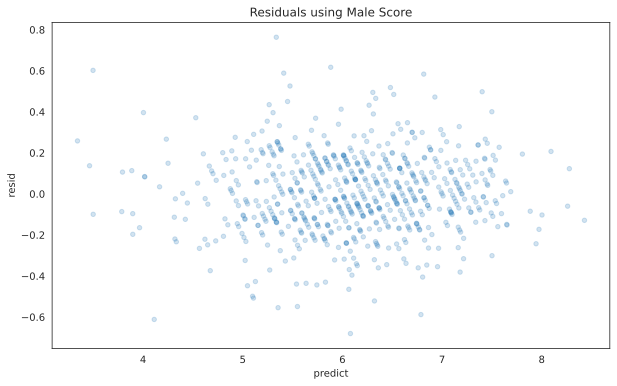

In [22]:
#Looking at residuals to check for outliers 
horror_df['predict']=pipe.predict(Xms)
horror_df['resid']=y-horror_df.predict
with sns.axes_style('white'):
    plot=horror_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.title('Residuals using Male Score')
plt.savefig('malescore_residual_scatter.svg',format='svg')

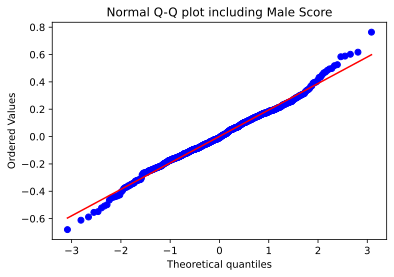

In [23]:
stats.probplot(horror_df['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot including Male Score")
plt.savefig('Male_score_qq.svg',format='svg')
plt.show()

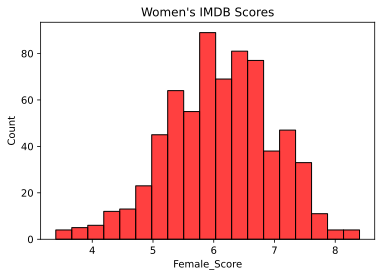

In [24]:
#looking at distribution of women's score
sns.histplot(horror_df.Female_Score, color='red')
plt.title("Women's IMDB Scores");
#sligtly left skewed
plt.savefig('Female_Score_hist.svg',format='svg')

In [25]:
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('rs', RobustScaler()),
                ('search',
                 GridSearchCV(cv=5, estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10,
       6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09,
       4.13201240e-09, 6.57933225e-09, 1.04761575e-08, 1.66810054e-08,
       2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07...
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10]),
                                          'fit_intercept': [True, False]}))]

In [30]:
#evaluating model performance
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, robust_pred)) # MAE and R-Squared are my useful metrics
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, robust_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, robust_pred)))

Mean Absolute Error: 0.16940440221836064


In [27]:
#from yellowbrick.regressor import PredictionError
#visualizer=PredictionError(pipe)
#visualizer.fit(X_train,y_train)
#visualizer.score(X_test,y_test)
#plt.savefig('Male_Score_Error.svg',format='svg')
#visualizer.show();

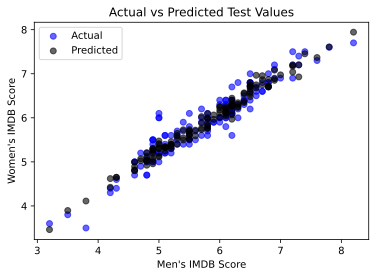

In [28]:
#Comparison of Actual scores and Scores predicted by Ridge Regression pipeline 
plt.scatter(X_test['Male_Score'],y_test, color='blue', alpha=0.6, label="Actual") #actual
plt.scatter(X_test['Male_Score'],robust_pred, color="black", alpha=0.6,label="Predicted")
plt.title('Actual vs Predicted Test Values')
plt.ylabel("Women's IMDB Score")
plt.xlabel("Men's IMDB Score")
plt.legend(); #predicted
plt.savefig('malescore_predicted_actual_scatter.svg',format='svg')

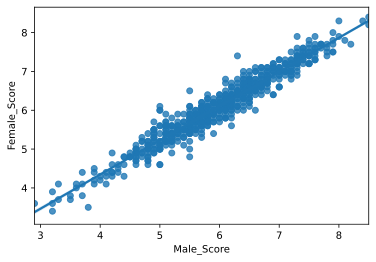

In [29]:
#linear regression plot
sns.regplot(x="Male_Score",y="Female_Score",data=horror_df);